In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
import time

# SPT


In [11]:
import math 
class ShiftedPatchTokenization(nn.Module):
    def __init__(self, in_dim, dim, merging_size=2, exist_class_t=False, is_pe=False):
        super().__init__()
        
        self.exist_class_t = exist_class_t
        
        self.patch_shifting = PatchShifting(merging_size)
        
        patch_dim = (in_dim*5) * (merging_size**2) 
        if exist_class_t:
            self.class_linear = nn.Linear(in_dim, dim)

        self.is_pe = is_pe
        
        self.merging = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = merging_size, p2 = merging_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        
        if self.exist_class_t:
            visual_tokens, class_token = x[:, 1:], x[:, (0,)]
            reshaped = rearrange(visual_tokens, 'b (h w) d -> b d h w', h=int(math.sqrt(x.size(1))))
            out_visual = self.patch_shifting(reshaped)
            out_visual = self.merging(out_visual)
            out_class = self.class_linear(class_token)
            out = torch.cat([out_class, out_visual], dim=1)
        
        else:
            out = x if self.is_pe else rearrange(x, 'b (h w) d -> b d h w', h=int(math.sqrt(x.size(1))))
            out = self.patch_shifting(out)
            out = self.merging(out)    
        
        return out
        
class PatchShifting(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.shift = int(patch_size * (1/2))
        
    def forward(self, x):
     
        x_pad = torch.nn.functional.pad(x, (self.shift, self.shift, self.shift, self.shift))
        # if self.is_mean:
        #     x_pad = x_pad.mean(dim=1, keepdim = True)
        
        """ 4 cardinal directions """
        #############################
        # x_l2 = x_pad[:, :, self.shift:-self.shift, :-self.shift*2]
        # x_r2 = x_pad[:, :, self.shift:-self.shift, self.shift*2:]
        # x_t2 = x_pad[:, :, :-self.shift*2, self.shift:-self.shift]
        # x_b2 = x_pad[:, :, self.shift*2:, self.shift:-self.shift]
        # x_cat = torch.cat([x, x_l2, x_r2, x_t2, x_b2], dim=1) 
        #############################
        
        """ 4 diagonal directions """
        # #############################
        x_lu = x_pad[:, :, :-self.shift*2, :-self.shift*2]
        x_ru = x_pad[:, :, :-self.shift*2, self.shift*2:]
        x_lb = x_pad[:, :, self.shift*2:, :-self.shift*2]
        x_rb = x_pad[:, :, self.shift*2:, self.shift*2:]
        x_cat = torch.cat([x, x_lu, x_ru, x_lb, x_rb], dim=1) 
        # #############################
        
        """ 8 cardinal directions """
        #############################
        # x_l2 = x_pad[:, :, self.shift:-self.shift, :-self.shift*2]
        # x_r2 = x_pad[:, :, self.shift:-self.shift, self.shift*2:]
        # x_t2 = x_pad[:, :, :-self.shift*2, self.shift:-self.shift]
        # x_b2 = x_pad[:, :, self.shift*2:, self.shift:-self.shift]
        # x_lu = x_pad[:, :, :-self.shift*2, :-self.shift*2]
        # x_ru = x_pad[:, :, :-self.shift*2, self.shift*2:]
        # x_lb = x_pad[:, :, self.shift*2:, :-self.shift*2]
        # x_rb = x_pad[:, :, self.shift*2:, self.shift*2:]
        # x_cat = torch.cat([x, x_l2, x_r2, x_t2, x_b2, x_lu, x_ru, x_lb, x_rb], dim=1) 
        #############################
        
        # out = self.out(x_cat)
        out = x_cat
        
        return out

# PreNorm

In [12]:
class PreNorm(nn.Module):
    def __init__(self, num_tokens, dim, fn):
        super().__init__()
        self.dim = dim
        self.num_tokens = num_tokens
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), ** kwargs)

# Attention


In [13]:
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

class Attention(nn.Module):
    def __init__(self, dim, num_patches, heads = 8, dim_head = 64, dropout = 0., is_LSA=False):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
        self.num_patches = num_patches
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.dim = dim
        self.inner_dim = inner_dim
        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(self.dim, self.inner_dim * 3, bias = False)
        init_weights(self.to_qkv)
        self.to_out = nn.Sequential(
            nn.Linear(self.inner_dim, self.dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
            
        if is_LSA:
            self.scale = nn.Parameter(self.scale*torch.ones(heads))    
            self.mask = torch.eye(self.num_patches+1, self.num_patches+1)
            self.mask = torch.nonzero((self.mask == 1), as_tuple=False)
        else:
            self.mask = None

    def forward(self, x, return_attn=False):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        if self.mask is None:
            dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        
        else:
            scale = self.scale
            dots = torch.mul(einsum('b h i d, b h j d -> b h i j', q, k), scale.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).expand((b, h, 1, 1)))
            dots[:, :, self.mask[:, 0], self.mask[:, 1]] = -987654321

        attn = self.attend(dots)
        out = einsum('b h i j, b h j d -> b h i d', attn, v) 
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        if return_attn:
            return out, attn
        return out
    
    def flops(self):
        flops = 0
        if not self.is_coord:
            flops += self.dim * self.inner_dim * 3 * (self.num_patches+1)
        else:
            flops += (self.dim+2) * self.inner_dim * 3 * self.num_patches  
            flops += self.dim * self.inner_dim * 3  

# FeedForward

In [14]:
class FeedForward(nn.Module):
    def __init__(self, dim, num_patches, hidden_dim, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_patches = num_patches
        
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )            
    def forward(self, x):
        return self.net(x)

# DropPath (Regularizacion)

In [15]:
import torch
from torch.nn import Module

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Obtained from: github.com:rwightman/pytorch-image-models
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(Module):
    """
    Obtained from: github.com:rwightman/pytorch-image-models
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

# Transformer


In [16]:
class Transformer(nn.Module):
    def __init__(self, dim, num_patches, depth, heads, dim_head, mlp_dim_ratio, dropout = 0., stochastic_depth=0., is_LSA=False):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.scale = {}

        for i in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(num_patches, dim, Attention(dim, num_patches, heads = heads, dim_head = dim_head, dropout = dropout, is_LSA=is_LSA)),
                PreNorm(num_patches, dim, FeedForward(dim, num_patches, dim * mlp_dim_ratio, dropout = dropout))
            ]))            
        self.drop_path = DropPath(stochastic_depth) if stochastic_depth > 0 else nn.Identity()
    
    def forward(self, x, return_attn=False):
        attn_maps = []
        for i, (attn, ff) in enumerate(self.layers):
            if return_attn:
                x_attn, attn_map = attn(x, return_attn=True)
                attn_maps.append(attn_map)
                x = self.drop_path(x_attn) + x
            else:
                x = self.drop_path(attn(x)) + x
            x = self.drop_path(ff(x)) + x            
            self.scale[str(i)] = attn.fn.scale
        if return_attn:
            return x, attn_maps
        return x

# ViT


In [17]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class ViT(nn.Module):
    def __init__(self, *, img_size, patch_size, num_classes, dim, depth, heads, mlp_dim_ratio, channels = 3, 
                 dim_head = 16, dropout = 0., emb_dropout = 0., stochastic_depth=0.,is_LSA=False, is_SPT=False):
        super().__init__()
        image_height, image_width = pair(img_size)
        patch_height, patch_width = pair(patch_size)
        self.num_patches = (image_height // patch_height) * (image_width // patch_width)
        self.patch_dim = channels * patch_height * patch_width
        self.dim = dim
        self.num_classes = num_classes
       
        if not is_SPT:
            self.to_patch_embedding = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
                nn.Linear(self.patch_dim, self.dim)
            )
            
        else:
            self.to_patch_embedding = ShiftedPatchTokenization(3, self.dim, patch_size, is_pe=True)
         
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, self.dim))
            
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(self.dim, self.num_patches, depth, heads, dim_head, mlp_dim_ratio, dropout, 
                                       stochastic_depth, is_LSA=is_LSA)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.dim),
            nn.Linear(self.dim, self.num_classes)
        )
        
        self.apply(init_weights)

    def forward(self, img, return_attn=False):
        # patch embedding
        
        x = self.to_patch_embedding(img)
            
        b, n, _ = x.shape
        
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
      
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        if return_attn:
            x, attn_maps = self.transformer(x, return_attn=True)
            return self.mlp_head(x[:, 0]), attn_maps
        
        x = self.transformer(x)      
        return self.mlp_head(x[:, 0])

# Preprocesado del dataset

Dataset cargado exitosamente.
Clases encontradas: 90
Número total de imágenes: 4320


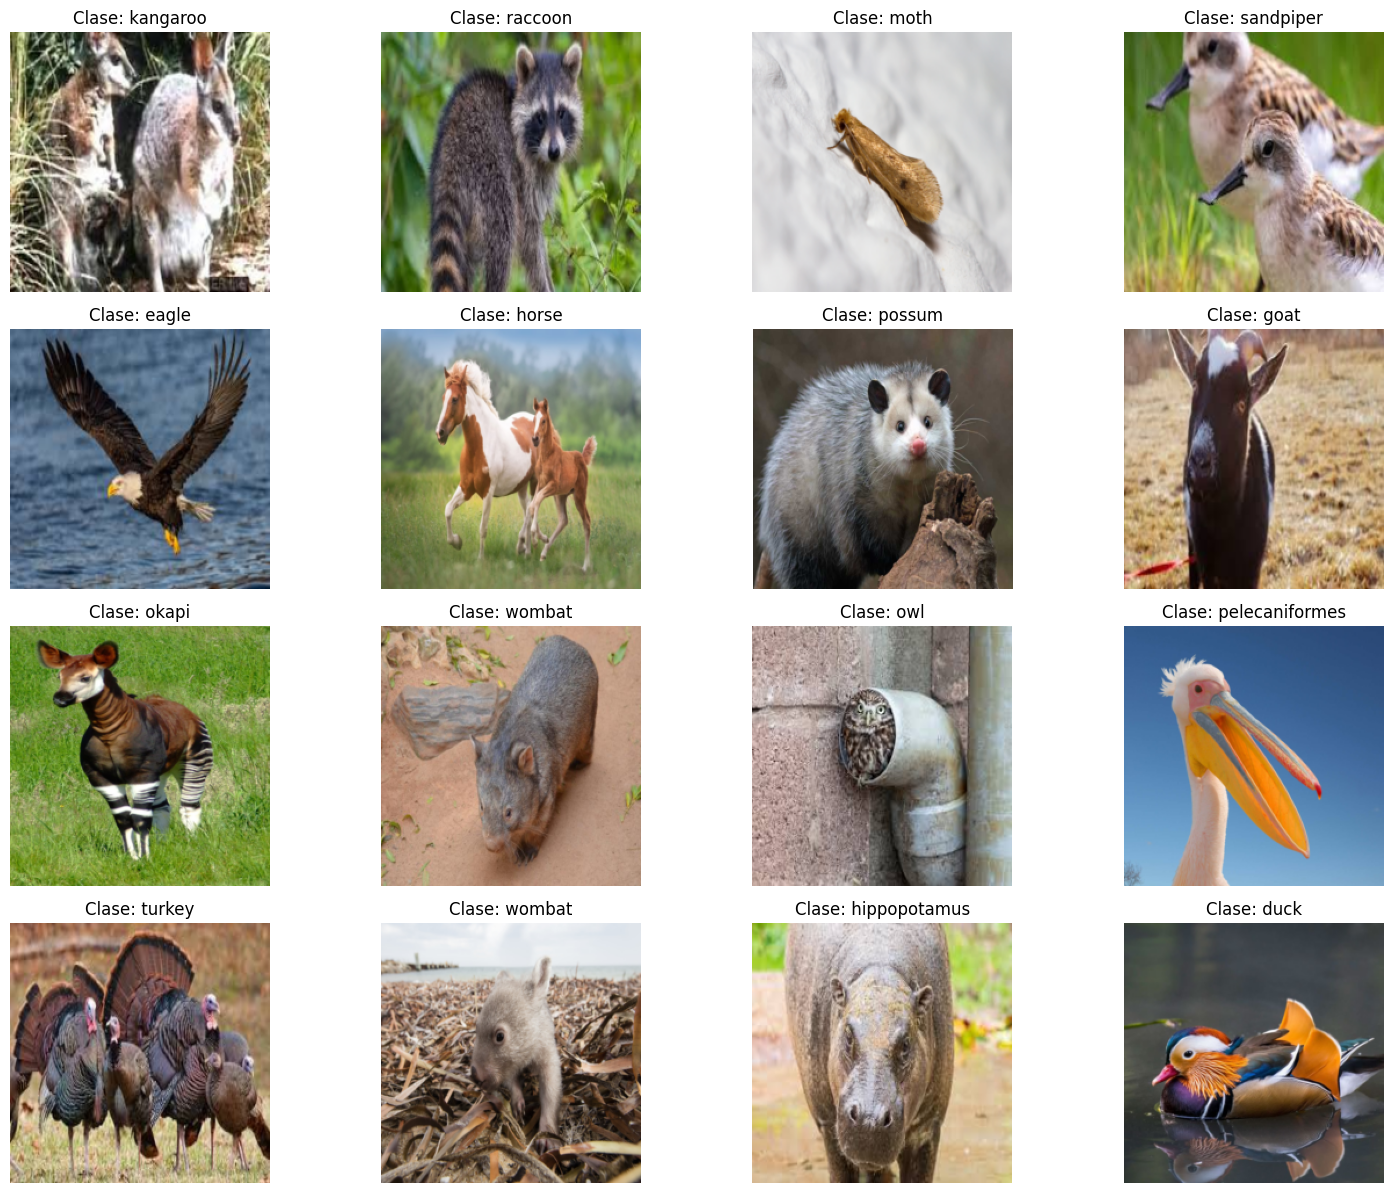

In [20]:
from torchvision import transforms, datasets
from torchvision.transforms.functional import to_pil_image
import random

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

DATA_PATH = 'dataset/'

# ImageFolder carga las imágenes y les asigna etiquetas según el nombre de la carpeta
train_data = datasets.ImageFolder(root=DATA_PATH + 'train/', transform=data_transforms)
print(f"Dataset cargado exitosamente.")
print(f"Clases encontradas: {len(train_data.classes)}")
print(f"Número total de imágenes: {len(train_data)}")

# 3. Función para mostrar imágenes (corregida y simplificada)
def show_images(dataset, num_samples=16, cols=4):
    """ Muestra una selección aleatoria de imágenes del dataset """
    if len(dataset) == 0:
        print("El dataset está vacío, no se pueden mostrar imágenes.")
        return

    plt.figure(figsize=(15, 15))
    # Selecciona índices aleatorios para mostrar una variedad de imágenes
    random_indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    for i, idx in enumerate(random_indices):
        # Obtenemos la imagen y su etiqueta del dataset
        image, label = dataset[idx]
        class_name = dataset.classes[label]

        # Creamos el subplot
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(to_pil_image(image))
        plt.title(f"Clase: {class_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 4. Llama a la función para visualizar las imágenes del dataset cargado
show_images(train_data)

# Inicialización del modelo

In [30]:
# --- Parámetros para el modelo ViT ---
img_size = 224  # Tamaño de la imagen de entrada (ej. 224x224)
patch_size = 16 # Tamaño de los parches (ej. 16x16)
num_classes = 90 # Número de clases para la clasificación (ej. ImageNet tiene 1000)
dim = 768 # Dimensión del embedding de los tokens (dimensión del modelo)
depth = 12 # Número de capas del Transformer
heads = 12 # Número de cabezas de atención
mlp_dim_ratio = 4 # Ratio para la dimensión oculta de la FFN (ej. 4 * dim)
channels = 3 # Número de canales de la imagen de entrada (3 para RGB)
dim_head = 64 # Dimensión de cada cabeza de atención (dim // heads)
dropout = 0.1 # Tasa de dropout general en el Transformer
emb_dropout = 0.1 # Tasa de dropout para el embedding posicional
stochastic_depth = 0.1 # Tasa de drop_path (Stochastic Depth)
is_LSA = True # Usar Localized Self-Attention (LSA)
is_SPT = True # Usar Shifted Patch Tokenization (SPT)

# --- Inicializar el modelo ViT ---
model = ViT(
    img_size = img_size,
    patch_size = patch_size,
    num_classes = num_classes,
    dim = dim,
    depth = depth,
    heads = heads,
    mlp_dim_ratio = mlp_dim_ratio,
    channels = channels,
    dim_head = dim_head,
    dropout = dropout,
    emb_dropout = emb_dropout,
    stochastic_depth = stochastic_depth,
    is_LSA = is_LSA,
    is_SPT = is_SPT
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Modelo ViT creado y movido a: {device}")
print(f"Número de parámetros del modelo: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Modelo ViT creado y movido a: cuda
Número de parámetros del modelo: 88207338


# Entrenamiento

In [31]:
from torch.utils.data import DataLoader

# 1. DataLoader
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 2. Pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 3. Ciclo de entrenamiento básico
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/10 - Loss: 4.6670


KeyboardInterrupt: 

In [ ]:
img_path = 'dataset/val/butterfly/6ef1439231.jpg'

# Carga la imagen con PIL
img = Image.open(img_path).convert('RGB')

# Aplica las mismas transformaciones que usaste en el dataset
image = data_transforms(img)  # Esto da un tensor [C, H, W]

# Si quieres usarlo en el modelo, agrega un batch dimension:
image = image.unsqueeze(0)  # Ahora es [1, C, H, W]

# Si usas el modelo directamente:
output, attn_maps = model(image.to(device), return_attn=True)

last_attn = attn_maps[-1][0]  # [heads, tokens, tokens]
cls_attn = last_attn[0, 0]    # atención del token CLS a todos los tokens

# El primer valor es el CLS, los siguientes son los parches
patch_attn = cls_attn[1:]  # (196,)

# Remapea a cuadrícula 14x14
num_patches = patch_attn.shape[0]
grid_size = int(math.sqrt(num_patches))  # 14 si tienes 196 parches

patch_attn_grid = patch_attn.reshape(grid_size, grid_size).cpu().detach().numpy()

img_np = np.array(img.resize((224, 224)))  # Asegúrate que el tamaño coincida

pred_class_idx = output.argmax(dim=1).item()

# Si tienes las clases cargadas desde ImageFolder:
val_data = datasets.ImageFolder(root=DATA_PATH + 'val/', transform=data_transforms)
class_name = val_data.classes[pred_class_idx]

print(f"Predicción: {class_name}")

plt.figure(figsize=(6, 6))
plt.imshow(img_np)  # Imagen de fondo
plt.imshow(patch_attn_grid, cmap='viridis', alpha=0.6, extent=(0, 224, 224, 0))  # Mapa de atención encima
plt.title("Attention map sobre la imagen")
plt.axis('off')
plt.colorbar()
plt.show()

NameError: name 'data_transforms' is not defined

In [21]:
from torch.utils.data import DataLoader
train_data_C10 = datasets.CIFAR10(root='./data_cifar10', train=True, download=True)
val_data_C10 = datasets.CIFAR10(root='./data_cifar10', train=False, download=True)
train_data_C10, val_data_C10

100%|██████████| 170M/170M [00:09<00:00, 17.5MB/s] 


Extracting ./data_cifar10\cifar-10-python.tar.gz to ./data_cifar10
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data_cifar10
     Split: Train,
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data_cifar10
     Split: Test)

In [22]:
train_data_C10[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [23]:
classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

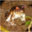

In [24]:
display(train_data_C10[0][0])

In [ ]:
# Transformaciones para CIFAR-10
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 224x224 para el ViT
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentación
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalización CIFAR-10
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Cargar datasets con transformaciones
train_dataset = datasets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transform_train)
val_dataset = datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform_val)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Dataset de entrenamiento: {len(train_dataset)} imágenes")
print(f"Dataset de validación: {len(val_dataset)} imágenes")
print(f"Número de batches de entrenamiento: {len(train_loader)}")
print(f"Número de batches de validación: {len(val_loader)}")

# Actualizar parámetros del modelo para CIFAR-10
img_size = 224
patch_size = 16
num_classes = 10  # CIFAR-10 tiene 10 clases
dim = 512  # Reducir dimensión para eficiencia
depth = 6  # Reducir profundidad
heads = 8
mlp_dim_ratio = 4
channels = 3
dim_head = 64
dropout = 0.1
emb_dropout = 0.1
stochastic_depth = 0.1
is_LSA = True
is_SPT = True

# Crear modelo
model = ViT(
    img_size=img_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim_ratio=mlp_dim_ratio,
    channels=channels,
    dim_head=dim_head,
    dropout=dropout,
    emb_dropout=emb_dropout,
    stochastic_depth=stochastic_depth,
    is_LSA=is_LSA,
    is_SPT=is_SPT
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Modelo creado y movido a: {device}")
print(f"Número de parámetros: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Función de entrenamiento
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Función de validación
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Configuración del entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Listas para guardar métricas
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Entrenamiento
num_epochs = 50
best_val_acc = 0.0

print("Iniciando entrenamiento...")
print("=" * 50)

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Entrenamiento
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validación
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Scheduler step
    scheduler.step()
    
    # Guardar métricas
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Tiempo del epoch
    epoch_time = time.time() - start_time
    
    # Imprimir resultados
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'  Time: {epoch_time:.2f}s, LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # Guardar mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_cifar10.pth')
        print(f'  ✓ Nuevo mejor modelo guardado! Val Acc: {best_val_acc:.2f}%')
    
    print("-" * 50)

print(f"Entrenamiento completado. Mejor accuracy de validación: {best_val_acc:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Dataset de entrenamiento: 50000 imágenes
Dataset de validación: 10000 imágenes
Número de batches de entrenamiento: 1563
Número de batches de validación: 313
Modelo creado y movido a: cuda
Número de parámetros: 20,986,938
Iniciando entrenamiento...
Batch 0/1563, Loss: 2.5265, Acc: 9.38%
Batch 100/1563, Loss: 1.8431, Acc: 21.63%
Batch 200/1563, Loss: 1.8429, Acc: 23.07%
Batch 300/1563, Loss: 1.6857, Acc: 25.71%
Batch 400/1563, Loss: 1.7768, Acc: 27.40%
Batch 500/1563, Loss: 1.6242, Acc: 29.26%
Batch 600/1563, Loss: 1.3736, Acc: 30.71%
Batch 700/1563, Loss: 1.3864, Acc: 31.74%
Batch 800/1563, Loss: 1.5004, Acc: 32.72%
Batch 900/1563, Loss: 1.6017, Acc: 33.70%
Batch 1000/1563, Loss: 1.6122, Acc: 34.52%
Batch 1100/1563, Loss: 1.3004, Acc: 35.16%
Batch 1200/1563, Loss: 1.2281, Acc: 35.91%
Batch 1300/1563, Loss: 1.4146, Acc: 36.63%
Batch 1400/1563, Loss: 1.5466, Acc: 37.41%
Batch 1500/1563, Loss: 1.2718, Acc: 38.00%
E

: 